<a href="https://colab.research.google.com/github/PedrinHm/Labs_Machine_Learning/blob/main/lab_do_pedrin_regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Projeto Prático - Regressão Linear (AirBnb)**


---


<br>
UNIRV - UNIVERSIDADE DE RIO VERDE<br>
Faculdade de Engenharia de Software<br><br>


**Aluno: Pedro Henrique Mendes**<br>
pedro.h.mendes@academico.unirv.edu.br<br>
**Prof. Me. Sandro Silva Moreira**<br>
sandro.moreira@unirv.edu.br<br><br>


---



In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
You are using TensorFlow version 2.12.0
Enable a GPU before running this notebook.


In [2]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 632.5 kB/s eta 0:00:00


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders.one_hot import OneHotEncoder, OrdinalEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.callbacks import EarlyStopping

In [19]:
# Carregando o arquivo CSV.

url = "http://data.insideairbnb.com/united-states/ny/new-york-city/2024-02-06/data/listings.csv.gz"

dataset = pd.read_csv(url)

In [20]:
# selecionando um subconjunto específico de colunas.

dataset = dataset[["neighbourhood_cleansed", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "price"]]

In [21]:
# fornece informações detalhadas sobre o DataFrame.

dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39202 entries, 0 to 39201
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  39202 non-null  object 
 1   property_type           39202 non-null  object 
 2   room_type               39202 non-null  object 
 3   accommodates            39202 non-null  int64  
 4   bathrooms               24335 non-null  float64
 5   bedrooms                33011 non-null  float64
 6   beds                    24222 non-null  float64
 7   price                   24267 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 2.4+ MB


In [ ]:
# Verificando tipos 'objetos'.

dataset.select_dtypes(include='object').describe()

,neighbourhood_cleansed,property_type,room_type,price
count,39202,39202,39202,24267
unique,224,80,4,914
top,Bedford-Stuyvesant,Entire rental unit,Entire home/apt,$100.00
freq,2760,16036,20853,653


In [ ]:
# Verificando tipos 'float'.

dataset.select_dtypes(include='float').describe()

In [ ]:
# Verificando tipos 'int'.

dataset.select_dtypes(include='int').describe()

In [22]:
# removendo valores nulos.
dataset = dataset.dropna()

# Convertendo 'price' para float e removendo o $.
dataset['price'] = dataset['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Usado para codificar variáveis categóricas em valores numéricos.
le = LabelEncoder()

# Selecionando as colunas categoricas.
dataset_categoricas = dataset[['neighbourhood_cleansed', 'property_type', 'room_type']]
for col in dataset_categoricas.columns:
    # Atribuindo os valores usando o .loc para modificar o DataFrame original.
    dataset_categoricas.loc[:, col] = le.fit_transform(dataset_categoricas[col])

scaler = StandardScaler()

# Selecionando as colunas numéricas.
dataset_numericas = dataset[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']]

dataset = pd.concat([dataset_numericas, dataset_categoricas], axis=1)

# Ajustando o scaler às colunas numéricas.
dataset = scaler.fit_transform(dataset)

<ipython-input-22-dd445bfbba3f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['price'] = dataset['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
<ipython-input-22-dd445bfbba3f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_categoricas.loc[:, col] = le.fit_transform(dataset_categoricas[col])
<ipython-input-22-dd445bfbba3f>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. 

In [23]:
print(dataset)

[[-0.9290842  -0.36523004 -0.38978879 ...  1.02613071  0.59606344
   1.11286624]
 [-0.46250922 -0.36523004 -0.38978879 ...  0.07291175  1.04744946
   1.11286624]
 [-0.9290842  -1.26427792 -0.38978879 ... -0.10865376  1.04744946
   1.11286624]
 ...
 [-0.46250922  2.33191361 -0.38978879 ... -1.21317732  0.14467741
   1.11286624]
 [ 0.47064074 -0.36523004  0.6425796  ... -0.30534974 -1.35994268
  -0.86924554]
 [-0.46250922 -0.36523004 -1.42215718 ...  1.41952266 -0.75809464
  -0.86924554]]


In [24]:
# Convertendo o array NumPy para DataFrame com os nomes das colunas.
col = ['neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']

dataset = pd.DataFrame(dataset, columns=col)

In [25]:
print(dataset)

       neighbourhood_cleansed  property_type  room_type  accommodates  \
0                   -0.929084      -0.365230  -0.389789     -0.544092   
1                   -0.462509      -0.365230  -0.389789     -0.544092   
2                   -0.929084      -1.264278  -0.389789     -1.340744   
3                   -0.929084      -0.365230  -0.389789     -0.544092   
4                   -0.929084       1.432866   2.707316     -0.544092   
...                       ...            ...        ...           ...   
24094                2.336941       1.432866   2.707316      1.845861   
24095               -0.462509       1.432866   1.674948     -0.544092   
24096               -0.462509       2.331914  -0.389789      1.049210   
24097                0.470641      -0.365230   0.642580      0.252559   
24098               -0.462509      -0.365230  -1.422157     -0.544092   

       bathrooms  bedrooms      beds     price  
0      -0.175553  1.026131  0.596063  1.112866  
1      -0.175553  0.07291

In [26]:
X = dataset.drop(columns=['price'])
y = dataset['price']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [27]:
# Criando a regularização L1
regularizer_l1 = l1(l=0.01)

# Criando a regularização L2
regularizer_l2 = l2(l=0.012)

# Combinando as duas
regularizer_combined = l1_l2(l1=0.01, l2=0.01)

In [28]:
##Criando arquitetura do modelo

model = Sequential()
model.add(Dense(32, activation='relu', kernel_regularizer=regularizer_l2, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                256       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [30]:
##compilando modelo

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mean_absolute_error'])

In [31]:
##Treinando modelo (completar)

history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
452/452 [==============================] - 2s 3ms/step - loss: 0.3854 - mean_absolute_error: 0.3870 - val_loss: 0.2097 - val_mean_absolute_error: 0.2077
Epoch 2/30
452/452 [==============================] - 1s 3ms/step - loss: 0.3582 - mean_absolute_error: 0.2967 - val_loss: 0.1802 - val_mean_absolute_error: 0.1822
Epoch 3/30
452/452 [==============================] - 1s 3ms/step - loss: 0.2054 - mean_absolute_error: 0.2398 - val_loss: 0.1478 - val_mean_absolute_error: 0.1618
Epoch 4/30
452/452 [==============================] - 1s 3ms/step - loss: 0.1572 - mean_absolute_error: 0.2063 - val_loss: 0.1252 - val_mean_absolute_error: 0.1431
Epoch 5/30
452/452 [==============================] - 2s 3ms/step - loss: 0.1300 - mean_absolute_error: 0.1839 - val_loss: 0.1081 - val_mean_absolute_error: 0.1336
Epoch 6/30
452/452 [==============================] - 2s 4ms/step - loss: 0.1112 - mean_absolute_error: 0.1691 - val_loss: 0.0949 - val_mean_absolute_error: 0.1247
Epoch 7/30
452/4

**Avaliando Resultados**

In [32]:
X_new = X_test[:3]

y_pred = model.predict(X_new)

print(y_pred)

1/1 [==============================] - 0s 74ms/step
[[-0.8718958 ]
 [ 1.0875064 ]
 [-0.87006485]]


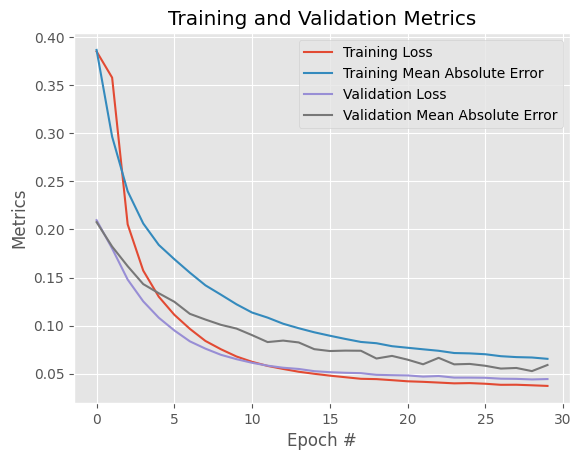

In [33]:
num_epochs = 30

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="Training Loss")
plt.plot(np.arange(0, num_epochs), history.history["mean_absolute_error"], label="Training Mean Absolute Error")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="Validation Loss")
plt.plot(np.arange(0, num_epochs), history.history["val_mean_absolute_error"], label="Validation Mean Absolute Error")
plt.title("Training and Validation Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Metrics")
plt.legend()
plt.show()


In [34]:
mse_test = model.evaluate(X_test,y_test)

151/151 [==============================] - 0s 2ms/step - loss: 0.0375 - mean_absolute_error: 0.0536


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")



Saved model to disk


In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
